In [1]:
from brian2 import *
# set_device('cpp_standalone') # for faster execution - builds a standalone C++ program

import NeuronEquations
import BrianHF
import numpy as np
from bimvee.importAe import importAe
from EvCamDatabase import DAVIS_346B

# TODO XXX: Turn all lists into numpy arrays for the sake of memory efficiency

In [2]:
# XXX: Extract the event stream using bimvee - needs refactoring to be more general
grid_width, grid_height= DAVIS_346B['width'], DAVIS_346B['height']
filePath = 'MVSEC_short_outdoor'
events = importAe(filePathOrName=filePath)

{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor'}
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/leftdvs'}
importIitYarp trying path: MVSEC_short_outdoor/leftdvs


100%|██████████| 38292/38292 [00:06<00:00, 5482.68it/s] 


Examining info.log: MVSEC_short_outdoor/leftdvs/info.log
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
{'filePathOrName': 'MVSEC_short_outdoor/rightdvs'}
importIitYarp trying path: MVSEC_short_outdoor/rightdvs


100%|██████████| 38024/38024 [00:05<00:00, 6515.51it/s] 


Examining info.log: MVSEC_short_outdoor/rightdvs/info.log


In [3]:
eventStream = events[0]['data']['left']['dvs']
eventStream.popitem()

('tsOffset', -0.0)

### Steps for the setting up the network:
1. Generate the input spikes
2. Set the parameters for the network (neurons and synapses)
3. Create the neuron group(s)
4. Create the synapses
5. Connect the synapses
6. Define the weights of the synapses
7. Set up monitors according to need
8. Run the simulation
9. (Optional) Visualize the results

#### _1. Generate the input spikes from the event stream_
###### _Brian Simulation Scope_


In [4]:
tau = 10
vt = 15
vr = 0
v0 = 20
gL = 1
K_GABA = 1
K_AMPA = 10
taugd = 5
tauad = 2
taugr = 0.25
tauar = 0.5
w_N = 80
w_G = 30
w_A = 50

# start_scope()
defaultclock.dt = 1*us
# HACK XXX: The input is now not in real time, must be fixed eventually to process real time event data
# Output is float, so we need to convert to Quantities (i.e give them units)
simTime, clockStep, inputSpikesGen = BrianHF.event_to_spike(eventStream, grid_width, grid_height, scale = 0.5)
defaultclock.dt = clockStep*ms

The maximum x index 345 while the width is 346
The maximum y index 259 while the height is 260
The x,y and time stamp indices are equal, the data is correct.
Checking for duplicate pairs...
Duplicate pairs found. Total Number of duplicates:  46
Total number of pairs/spikes prior to removing duplicates:  2761653  pairs.
Removing duplicate pairs...
Done. Total number of pairs/spikes:  2761607  pairs.
The selected scale is 0.5
The maximum time stamp (scaled) 9999.909 ms.
The recommended simulation time (scaled) is 10000.0 ms.
The minimum time step (scaled) is 0.24949999999989814 ms.
The recommended clock time step (scaled) is 0.25 ms.


#### _2. Set the parameters for the network (neurons and synapses)_
Parameter values can be tuned at the top of the document (this is done for clarity purposes).

In [5]:
# Neuron Parameters
N_Neurons = grid_width * grid_height    # Number of neurons
tau = tau*ms    # Time constant
vt = vt*mV    # Threshold Voltage
vr = vr*mV    # Reset Voltage
v0 = v0*mV    # Resting Voltage - Not necessarily used
gL = gL/ms    # Leak Conductance - Not necessarily used

'''
    Neighborhood Size (num_Neighbors) - Affects the number of neighbors a central neuron based on the L1 Distance
    Neighboring Neurons --> (abs(X_pre - X_post) <= num_Neighbors  and abs(Y_pre - Y_post) <= num_Neighbors)
'''
num_Neighbors = 1

Eqs_Neurons = NeuronEquations.EQ_LIF    # Neuron Equations

# Synapse Parameters
K_GABA = K_GABA
K_AMPA = K_AMPA
taugd = taugd * ms
tauad = tauad * ms
taugr = taugr * ms
tauar = tauar * ms

#### _3. Create the neuron group(s)_

In [6]:
# TODO XXX: The events are running on the clockStep, I should at least fix them to use the (event_driven) setting in Brian2
neuronsGrid = NeuronGroup(N_Neurons, Eqs_Neurons, threshold='v>vt', reset='v = vr', refractory=1 * ms, method='euler')

# FIXME: Verify the grid coordinates and assign the X and Y values to the neurons accordingly
# Generate x and y values for each neuron
x_values = np.repeat(np.arange(grid_width), grid_height)
y_values = np.tile(np.arange(grid_height), grid_width)
neuronsGrid.X = x_values
neuronsGrid.Y = y_values

#### _4. Create the synapses_

In [7]:
Syn_Input_Neurons = Synapses(inputSpikesGen, neuronsGrid, 'w : volt/second', on_pre='Ia1 += w')
Syn_Neurons_GABA = Synapses(neuronsGrid, neuronsGrid, 'w : volt/second', on_pre='Ig1 -= w')
Syn_Neurons_AMPA = Synapses(neuronsGrid, neuronsGrid, 'w : volt/second', on_pre='Ia1 += w')

#### _5. Connect the synapses_

In [8]:
Syn_Input_Neurons.connect(condition= 'i==j')    # Connect the first synapses from input to G_neurons on a 1 to 1 basis
Syn_Neurons_GABA.connect(condition='i != j and abs(X_pre - X_post) <= num_Neighbors and abs(Y_pre - Y_post) <= num_Neighbors')    # Connect the second group of synapses from a neuron to its neighbors
Syn_Neurons_AMPA.connect(condition='i == j')     # Connect the last set of synapses from a neuron to itself (recurrent)

#### _6. Define the weights of the synapses_

In [9]:
Syn_Input_Neurons.w = w_N * volt/second
Syn_Neurons_GABA.w = w_G * volt/second
Syn_Neurons_AMPA.w = w_A * volt/second

#### _7. Set up monitors_

In [10]:
SpikeMon_Input = SpikeMonitor(inputSpikesGen)    # Monitor the spikes from the input
SpikeMon_Neurons = SpikeMonitor(neuronsGrid)    # Monitor the spikes from the neuron grid
StateMon_Neurons = StateMonitor(neuronsGrid, variables=True, record=True)    # Monitor the state variables - True for all variables

In [11]:
# store('PreSim', 'PreSimulationState')    # Store the state of the simulation before running

### _8. Run the simulation_

In [ ]:
net = Network(collect())
net.run(simTime*ms, profile=True)
profiling_summary(net.profiling_info)

In [12]:
run(simTime*ms, profile=True)

In [ ]:
# store('SimOut', 'SimulationOutput')   # Store the state of the simulation after running
# profiling_summary()

#### _9. (Optional) Visualize the results_

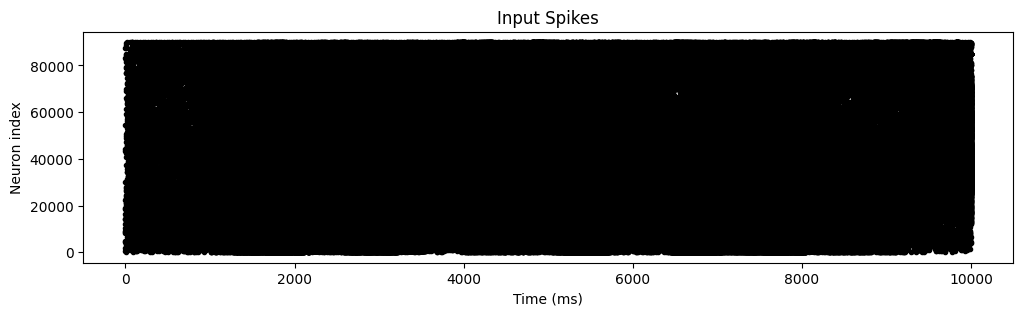

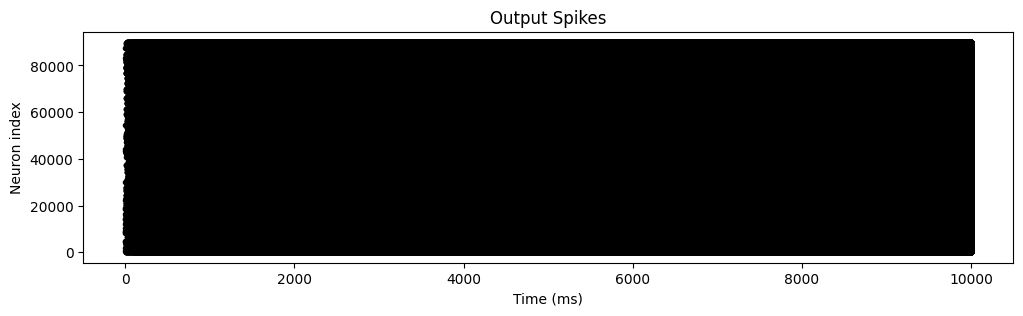

In [13]:
# VISUALISATION
BrianHF.visualise_spikes([SpikeMon_Input], figSize=(12,3), figTitle='Input Spikes')
BrianHF.visualise_spikes([SpikeMon_Neurons], figSize=(12,3), figTitle='Output Spikes')

# Ploting the interspike interval
# BrianHF.visualise_interSpikeInterval(SpikeMon_Neurons, [5])
# BrianHF.visualise_neurons_states(StateMon_Neurons, [4, 5], 'all')    

In [ ]:
'''
BUG: For some reason, generating a network object and running it causes an error:
     "RuntimeError: spikegeneratorgroup has already been simulated, cannot add it
      to the network. If you were trying to remove and add an object to temporarily stop it from being run, set its active flag to False instead."

HACK: This is a hack to avoid the weird error that happens when using a network object
      and not the magic version of the run function 'run()
'''
if False:
    try:
        net = Network(collect())
        net.store('PreSim', 'PreSimulationState')
        net.run(simTime*ms, report=BrianHF.ProgressBar(), report_period=1*second, profile=True)
        net.store('SimOut', 'SimulationOutput')
        profiling_summary(net.profiling_info)
    except RuntimeError as e:
        print(f"HACK: I have no idea why this error happens. Might be a bug in\
            the library.\n{e}")
        
        store('PreSim', 'PreSimulationState')
        run(simTime*ms, report=BrianHF.ProgressBar(), report_period=1*second, profile=True)
        store('SimOut', 'SimulationOutput')
        profiling_summary(profiling_info)